### Cost Benefit Questions

1. How would you rephrase the business problem if your model was optimizing toward _precision_? i.e., How might the model behave differently, and what effect would it have?
2. How would you rephrase the business problem if your model was optimizing toward _recall_?
3. What would the most ideal model look like in this case?


In [ ]:
import pandas as pd
import sklearn.linear_model as lm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LogisticRegression

titanic = pd.read_csv('C:/Users/BeckyC/Desktop/Data Science - GA files/titanic.csv')
titanic.set_index('PassengerId', inplace=True) # drop passenger ID
titanic = titanic.join(pd.get_dummies(titanic.Pclass))
titanic['is_male'] = titanic.Sex.apply(lambda x: 1 if x == 'male' else 0)

titanic.groupby('Survived').Age.hist()

In [ ]:
titanic['Age'] = titanic.groupby(["Sex", 'Pclass']).Age.transform(lambda x: x.fillna(x.mean()))
titanic['had_parents'] = titanic.Parch.apply(lambda x: 1 if x > 0 else 0)
titanic['had_siblings'] = titanic.SibSp.apply(lambda x: 1 if x > 0 else 0)

In [ ]:
from sklearn import grid_search, cross_validation

feature_set = titanic[['is_male', 1, 2, 'Fare', 'Age', 'had_parents', 'had_siblings']]
cv=cross_validation.KFold(n=len(titanic), n_folds=10)
gs = grid_search.GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={'C': [10**-i for i in range(-5, 5)], 'class_weight': [None, 'balanced']},
    cv=cv,
    scoring='roc_auc'
)


gs.fit(feature_set, titanic.Survived)
print(gs.best_estimator_)

In [ ]:
titanic['prob'] = gs.predict_proba(feature_set).T[1]
titanic['predict'] = gs.predict(feature_set)
print(titanic[titanic.predict == 1].prob.min())
print(titanic[titanic.predict == 0].prob.max())

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

mod = gs.best_estimator_

actuals = mod.predict(feature_set) 
probas = mod.predict_proba(feature_set)
plt.plot(roc_curve(titanic[['Survived']], probas[:,1])[0], roc_curve(titanic[['Survived']], probas[:,1])[1])

In [ ]:
for c in [10**-i for i in range(-5, 5)]:
    for class_weight in [None, 'balanced']:
        gs_ind = grid_search.GridSearchCV(
        estimator=LogisticRegression(),
        cv=cv,
        param_grid={'C': [c], 'class_weight': [class_weight]},
        scoring='roc_auc')
        
        gs_ind.fit(feature_set, titanic.Survived)
        actuals = gs_ind.predict(feature_set) 
        probas = gs_ind.predict_proba(feature_set)
        plt.plot(roc_curve(titanic[['Survived']], probas[:,1])[0], roc_curve(titanic[['Survived']], probas[:,1])[1])

In [ ]:
plt.plot(roc_curve(titanic[['Survived']], actuals)[0], roc_curve(titanic[['Survived']], actuals)[1])

In [ ]:
roc_auc_score(titanic['Survived'], mod.predict(feature_set))

In [ ]:
import numpy as np
score = []
for train, test in cv:
    score.append(roc_auc_score(titanic.Survived.iloc[test], mod.predict_proba(feature_set.iloc[test])[:,1]))
print(np.mean(score))

### Visualizing models over variables

In [5]:
%matplotlib inline

In [1]:
import pandas as pd
import sklearn.linear_model as lm
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('C:/Users/BeckyC/Desktop/Data Science - GA files/flight_delays.csv')
df = df.loc[df.DEP_DEL15.notnull()].copy()

In [2]:
df.head()

,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,CARRIER,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,CRS_DEP_TIME,DEP_TIME,DEP_DEL15,Unnamed: 15
0,1,4,2015-01-01,AA,19805,AA,12478,1247802,31703,12892,1289203,32575,900,855.0,0.0,NaN
1,1,4,2015-01-01,AA,19805,AA,12892,1289203,32575,12478,1247802,31703,900,856.0,0.0,NaN
2,1,4,2015-01-01,AA,19805,AA,12478,1247802,31703,12892,1289203,32575,1230,1226.0,0.0,NaN
3,1,4,2015-01-01,AA,19805,AA,12892,1289203,32575,12478,1247802,31703,1220,1214.0,0.0,NaN
4,1,4,2015-01-01,AA,19805,AA,11298,1129803,30194,12173,1217302,32134,1305,1754.0,1.0,NaN


In [5]:
# df = df[df.DEP_DEL15.notnull()]
# df = df.join(pd.get_dummies(df['CARRIER'], prefix='carrier'))
df = df.join(pd.get_dummies(df['DAY_OF_WEEK'], prefix='dow'))
model = lm.LogisticRegression()
features = [i for i in df.columns if 'dow_' in i]



In [6]:
df.shape
features

['dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6', 'dow_7']

In [7]:
features += ['CRS_DEP_TIME']
model.fit(df[features[1:]], df['DEP_DEL15'])

df['probability'] = model.predict_proba(df[features[1:]]).T[1]
features

['dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6', 'dow_7', 'CRS_DEP_TIME']

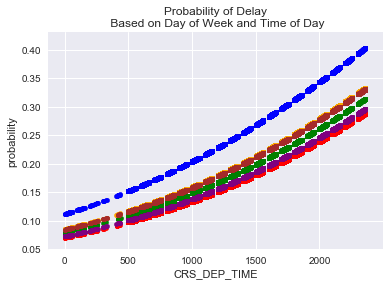

In [12]:
ax = plt.subplot(111)
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']
for e, c in enumerate(colors): #loops over a list and assigns an index of 0 for false and 1 for True.
                                #so it creates a dummy variable blue 0, blue 1, green 0, green 1 etc 
                                #it returns 2 variable e = index ( 0 or 1) and c = colour
    df[df[features[e]] == 1].plot(x='CRS_DEP_TIME', y='probability', kind='scatter', color = c, ax=ax)
                                #==1 tells us to only include observations that match the colour index.
                                

ax.set(title='Probability of Delay\n Based on Day of Week and Time of Day')


In [13]:
features

['dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6', 'dow_7', 'CRS_DEP_TIME']

### Other Answers: visualizing Airline or the inverse

In [32]:
:features = [i for i in df.columns if 'carrier_' in i] #if column contains 'carrier_' then add column name to features.
features += ['CRS_DEP_TIME'] #append time
:
#model = lm.LogisticRegression
model.fit(df[features[1:]], df['DEP_DEL15'])

#drops carrier_AA and transposes probability to the dataframe.
df['probability'] = model.predict_proba(df[features[1:]]).T[1]

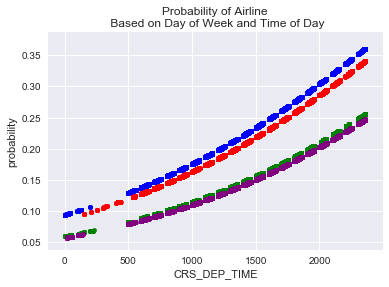

In [33]:
ax = plt.subplot(111)
colors = ['blue', 'green', 'red', 'purple']#, 'orange', 'brown']
for e, c in enumerate(colors): #loops over a list and assigns an index of 0 for false and 1 for True.
                                #so it creates a dummy variable blue 0, blue 1, green 0, green 1 etc 
                                #it returns 2 variable e = index ( 0 or 1) and c = colour
    df[df[features[e]] == 1].plot(x='CRS_DEP_TIME', y='probability', kind='scatter', color = c, ax=ax)
                                #==1 tells us to only include observations that match the colour index.
                                

ax.set(title='Probability of Airline\n Based on Day of Week and Time of Day')



In [37]:
features[1:5]

['carrier_AS', 'carrier_B6', 'carrier_DL', 'carrier_EV']

### Visualizing Performance Against Baseline

#### Visualizing AUC and comparing Models

In [38]:
from sklearn import dummy, metrics

In [62]:
model0 = dummy.DummyClassifier() # This is randomly applying a 0 or 1 prediction, see below blue line on ROC below, 
                                 # it results in AUC of 0.5
model0.fit(df[features[1:]], df['DEP_DEL15'])
df['probability_0'] = model0.predict_proba(df[features[1:]]).T[1]

model1 = lm.LogisticRegression()
model.fit(df[features[1:]], df['DEP_DEL15'])
df['probability_1'] = model.predict_proba(df[features[1:]]).T[1]


In [40]:
df.shape

(458311, 40)

[(0, 1),
 (0, 1),

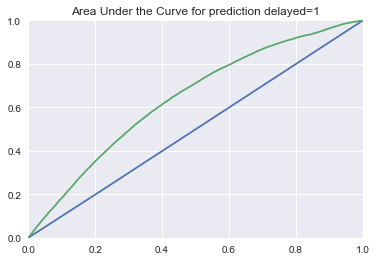

In [63]:
ax = plt.subplot(111)
vals = metrics.roc_curve(df.DEP_DEL15, df.probability_0)
ax.plot(vals[0], vals[1])
vals = metrics.roc_curve(df.DEP_DEL15, df.probability_1)
ax.plot(vals[0], vals[1])

ax.set(title='Area Under the Curve for prediction delayed=1', ylabel='', xlabel='', xlim=(0, 1), ylim=(0, 1))

##HOW TO SHOW AUC?

#### Visualizing Precision / Recall

In [ ]:
#TBC...
ax = plt.subplot(111)
for i in range(2):
    vals = metrics.precision_recall()
    ax.plot(vals[1], vals[0])

# Refining features
Which are categorical?
Which are significant?


DAY_OF_MONTH            -0.190200
DAY_OF_WEEK              0.018531
AIRLINE_ID               0.015895
ORIGIN_AIRPORT_ID       -0.005450
ORIGIN_AIRPORT_SEQ_ID   -0.005451
ORIGIN_CITY_MARKET_ID   -0.038579
DEST_AIRPORT_ID          0.018237
DEST_AIRPORT_SEQ_ID      0.018236
DEST_CITY_MARKET_ID      0.006000
CRS_DEP_TIME             0.154011
DEP_TIME                 0.217364
DEP_DEL15                1.000000
carrier_AA               0.005222
carrier_AS              -0.030482
carrier_B6               0.009770
carrier_DL              -0.070378
carrier_EV              -0.005851
carrier_F9               0.024761
carrier_HA              -0.032541
carrier_MQ               0.058986
carrier_NK               0.017269
carrier_OO               0.015765
carrier_UA               0.041097
carrier_US              -0.039457
carrier_VX              -0.010439
carrier_WN               0.017756
dow_1                    0.037309
dow_2                   -0.019004
dow_3                   -0.037984
dow_4         

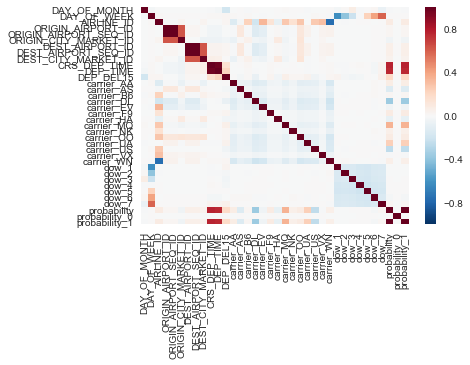

In [61]:
#df.set_index('Unnamed: 15', inplace=True)
sns.heatmap (df.corr())
df.corr().DEP_DEL15
features = ['CRS_DEP_TIME','DEP_TIME', ]